# Single adaptive Kramers chain



In [1]:
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from dilutebrowniandynamics.simulate import simulate
from dilutebrowniandynamics.molecules.adaptive_Kramers_chain import AdaptiveKramersChain

np.random.seed(2024)

## Parameters definition

In [2]:
n_links = 1024       # Number of segments in the Kramers chain 64, 256, 1024

dt = .01           # Time step value (dimensionless)
n_steps = 2000     # Number of time steps to simulate
write_interval = 10 # How often data is recorded (1 means every time step)
n_proc = 16        # Number of processor cores to use (for batch processing)

output_file = 'outputs/single_chain_vtk'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
# Starting vectors
molecule = AdaptiveKramersChain.from_normal_distribution(n_links)

We can plot this molecule using matplotlib 3d capabilities: firt we need to convert links to coordinates.

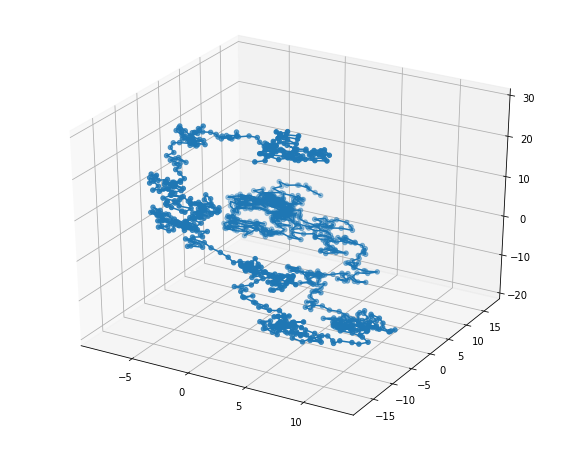

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = molecule.coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
ax.plot(x, y, z)
ax.scatter(x, y, z, s=20)

Or we can export the molecule to vtk format which can be read by Paraview.

In [5]:
molecule.save_vtk('outputs/single_chain_vtk/example.vtk')

## Initial relaxation
Thermalisation step.

In [6]:
gradU = np.zeros((3, 3))
observables, molecule_init = simulate(molecule, gradU, dt, n_steps,
                                     write_interval=write_interval, full_trajectory=False, progress=True)

 30%|██▉       | 591/2000 [00:05<00:13, 105.97it/s]


KeyboardInterrupt: 

In [ ]:
t = np.arange(n_steps//write_interval)*dt*write_interval
plt.plot(t, observables['A'][:,0,0])

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [ ]:
# Rescale factor
# --------------
Wi_max = 1000
f = Wi_max/(0.0142*n_links**2)

# Build scenario
# --------------
scenario = np.load('inputs/sonication/scenario_sonication_0.npz')
t_base = scenario['t']
t_base = t_base/f
gradU_base = scenario['gradU']*f
gradU = interp1d(t_base, gradU_base, axis=0, kind='linear', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

n_steps = int(t_base[-1]/dt)
write_interval = 1000

plt.semilogy(gradU_base[:,0,0])
plt.axhline(0.5/(0.0142*n_links**2), ls=':', label='coil-stretch')
plt.legend()

In [ ]:
observables, trajectory = simulate(molecule_init, gradU, dt, n_steps,
                                     write_interval=write_interval, full_trajectory=True, progress=True)

In [ ]:
#%load_ext line_profiler
#%lprun -f simulate simulate(molecule, gradU, 1000, 0.01, full_trajectory=False, progress=True)

In [ ]:
#%lprun -f AdaptiveKramersChain.solve molecule.solve(np.zeros((3,3)), 0.001)

In [ ]:
for i in range(0,len(trajectory)):
    trajectory[i].save_vtk(f'outputs/single_chain_vtk/time_{i}.vtk')